## Notebook for Solar Wind Exploration

In the initial phase, we want to see if we can detect FTEs using unsupervised learning, by finding a manifold for the solar wind data.

The initial hypothesis is the transition matrices (Markov Matrices $M$) that can be derived from Manifolder + clustering will show distinctive clusters and transitions.  We can check accuracy by looking at the label (FTE or not?), and see if this label could have been deduced from the data itself.



In [1]:
# useful set of python includes

%load_ext autoreload
%autoreload 2

import numpy as np

np.set_printoptions(suppress=True, precision=4)

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

import seaborn as sns
sns.set()

import pandas as pd

import time

import random

### Load Solar Wind Data, and Run Manifolder

The `dataset_2` file contains 

Dataset-2 (THEMIS):   a list with FTEs periods and non-FTEs periods observed by THEMIS in 2007.  These are combined into one file, randomly FTE - NonFTE - FTE - FTE, NonFTE, etc…

In total there are 63 FTEs and 47 non-FTEs.

The time series are separated by one blank line, and each one has 1440 points in a period of 6 minutes.


In [3]:
import sys
sys.path.append(r"C:\Users\acloninger\GDrive\ac2528Backup\DocsFolder\GitHub\manifolder")
sys.path.append(r"..")

import manifolder as mr
from manifolder import helper as mh


In [4]:
# load the data
# note, you must have started the notebook in the 

print('loading data ...')
df = pd.read_excel('astro_data/dataset_2.xlsx', index_col=0)
df.head()


loading data ...


,bx\t,by\t,bz\t,bl\t,bm\t,bn\t,bmag\t,vx\t,vy\t,vz\t,vmag\t,np,Unnamed: 13,tpar,tper,tp,goal
sc time,,,,,,,,,,,,,,,,,
thd,1.177999e+09,2.06,-4.87,17.77,17.80,4.55,-2.48,18.54,-5.96,2.42,6.94,9.46,0.11,3938.25,3565.04,3689.44,1.0
thd,1.177999e+09,2.01,-4.89,17.69,17.72,4.53,-2.53,18.47,-7.04,1.11,6.79,9.85,0.11,3924.28,3610.40,3715.03,1.0
thd,1.177999e+09,2.01,-4.87,17.71,17.74,4.51,-2.52,18.48,-8.14,-0.21,6.66,10.52,0.11,3910.35,3656.06,3740.82,1.0
thd,1.177999e+09,2.02,-4.80,17.74,17.77,4.47,-2.45,18.48,-9.23,-1.53,6.52,11.40,0.11,3896.40,3701.56,3766.51,1.0
thd,1.177999e+09,1.99,-4.83,17.70,17.73,4.47,-2.50,18.45,-10.26,-2.82,6.37,12.40,0.11,3882.37,3746.46,3791.77,1.0


In [5]:
# convert values from loaded spreadsheet, into a numpy matrices
# note that there is no need for the first value, which is time,
# as it is not part of the manifold
#
# also, note the spreadsheet is missing a column name for `Unnamed: 13`, and the values above
# this have the incorrect column labels; the first relevant vale is bx, which as a magnitude around 2
#
# note the final value of each row is the goal (0 or 1), and not part of z

data_raw = df.values[:, 1:]
print('first line of raw_data:\n', data_raw[0, :])


first line of raw_data:
 [   2.06   -4.87   17.77   17.8     4.55   -2.48   18.54   -5.96    2.42
    6.94    9.46    0.11 3938.25 3565.04 3689.44    1.  ]


In [6]:
import pickle
#Load Data
segments = np.load('themis\segments-newdata-all.npy')

# Load Labels
labels = np.load('themis\labels-newdata-all.npy')
labels = np.asarray(pd.get_dummies(labels))

#Load Bounding Boxes/ Event Locations
with open('themis/bbox.pickle','rb') as f:
    bboxes = pickle.load(f)

In [24]:
# loop through the data, breaking out the clusters
# i will always point to the NaN (blank line) in the dataframe,
# and values [i-1440:i] is the snipped

snippet_len = 1440

# collect all line breaks (blank lines) in csv file
#lineBreaks = [0]
#for i in range(data_raw.shape[0]):
#    if data_raw[i,0] != data_raw[i,0]:  # replacement of isnan, since nan != nan
#        lineBreaks.append(i)    
#lineBreaks.append(data_raw.shape[0])
#
#num_snippet = len(lineBreaks)-1


# callect the snippets into two groups, one for each goal (target) value, 0 or 1
# these can be easily merged
zs_0 = []
zs_1 = []

locallabel_0 = []
locallabel_1 = []
snippet_index = 0;

df.values[0,:]

reduce_dimension = True

for i in range(snippet_len,data_raw.shape[0],snippet_len+1):
    # copy the snipped, excluding the last value, which is the goal
    snippet = data_raw[i-snippet_len:i,:-1]
    
    if reduce_dimension:
        snippet = snippet[:,5]
        snippet = snippet.reshape(snippet_len,1)

    # grab the goal value from the first row of each snippet
    goal = data_raw[i-snippet_len,-1]
    
    # check to make sure each snippet does not contain NaN
    # (should not, if parsing is correct)
    assert ~np.isnan(snippet).any(), 'oops, snippet contains a Nan!'
    
    print('snippet size',snippet.shape,'with goal',goal)
    
    snippetlabel = np.zeros(snippet_len)
    if goal == 1:
        bmin = int(bboxes[snippet_index][0][0])
        bmax = int(bboxes[snippet_index][0][2])
        snippetlabel[bmin:bmax] = 1
    
    if goal == 0:
        zs_0.append( snippet )
        locallabel_0.append( snippetlabel )
    elif goal == 1:
        zs_1.append( snippet )
        locallabel_1.append( snippetlabel )
    else:
        assert False, 'value of goal not understood'
        
    snippet_index = snippet_index + 1;
        

# shuffle this lists; this should not strictly be necessary, if all the data is being used,
# but prevents biases when shortening the list

c0 = list(zip(zs_0, locallabel_0))
random.shuffle(c0)
zs_0, locallabel_0 = zip(*c0)
zs_0 = list(zs_0)
locallabel_0 = list(locallabel_0)

c1 = list(zip(zs_1, locallabel_1))
random.shuffle(c1)
zs_1, locallabel_1 = zip(*c1)
zs_1 = list(zs_1)
locallabel_1 = list(locallabel_1)

shorten_data = False

if shorten_data:
    zs_0 = zs_0[:20]
    zs_1 = zs_1[:20]
    locallabel_0 = locallabel_0[:20]
    locallabel_1 = locallabel_1[:20]
        
zs = zs_0 + zs_1
locallabel = locallabel_0 + locallabel_1
z_breakpoint = len(zs_0)

print( '\done!')
print( '\t len(zs_0):',len(zs_0))
print( '\t len(zs_1):',len(zs_1))
print( '\t len(zs):',len(zs))


snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
snippet size (1440, 1) with goal 1.0
snippet size (1440, 1) with goal 0.0
s

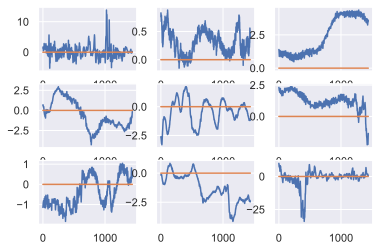

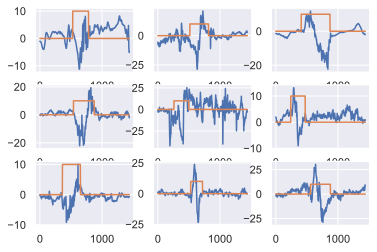

In [25]:
import matplotlib.pyplot as plt

plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(zs_0[i][:,5])
    else:
        plt.plot(zs_0[i][:,0])
        
    plt.plot(10*locallabel_0[i])
    
plt.show()

plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(zs_1[i][:,5])
    else:
        plt.plot(zs_1[i][:,0])
    plt.plot(10*locallabel_1[i])

    
plt.show()

In [84]:
# data has been parsed, now run Manifolder

dim=8
H = 160
step_size = 20
nbins = 10
ncov = 10

start_time = time.time()

# create manifolder object
manifolder = mr.Manifolder(dim=dim,H=H,step_size=step_size,nbins=nbins, ncov=ncov)

# add the data, and fit (this runs all the functions)
manifolder.fit_transform(zs, parallel=False)

elapsed_time = time.time() - start_time
print('\n\t Program Executed in', str(np.round(elapsed_time, 2)), 'seconds')  # about 215 seconds (four minutes)


calculating histograms for snip  0  of  103  (dim  1  timeseries) . done
calculating histograms for snip  1  of  103  (dim  1  timeseries) . done
calculating histograms for snip  2  of  103  (dim  1  timeseries) . done
calculating histograms for snip  3  of  103  (dim  1  timeseries) . done
calculating histograms for snip  4  of  103  (dim  1  timeseries) . done
calculating histograms for snip  5  of  103  (dim  1  timeseries) . done
calculating histograms for snip  6  of  103  (dim  1  timeseries) . done
calculating histograms for snip  7  of  103  (dim  1  timeseries) . done
calculating histograms for snip  8  of  103  (dim  1  timeseries) . done
calculating histograms for snip  9  of  103  (dim  1  timeseries) . done
calculating histograms for snip  10  of  103  (dim  1  timeseries) . done
calculating histograms for snip  11  of  103  (dim  1  timeseries) . done
calculating histograms for snip  12  of  103  (dim  1  timeseries) . done
calculating histograms for snip  13  of  103  (d

computing local covariances for snip  9  of  103......... done
computing local covariances for snip  10  of  103......... done
computing local covariances for snip  11  of  103......... done
computing local covariances for snip  12  of  103......... done
computing local covariances for snip  13  of  103......... done
computing local covariances for snip  14  of  103......... done
computing local covariances for snip  15  of  103......... done
computing local covariances for snip  16  of  103......... done
computing local covariances for snip  17  of  103......... done
computing local covariances for snip  18  of  103......... done
computing local covariances for snip  19  of  103......... done
computing local covariances for snip  20  of  103......... done
computing local covariances for snip  21  of  103......... done
computing local covariances for snip  22  of  103......... done
computing local covariances for snip  23  of  103......... done
computing local covariances for snip  24 

In [85]:
locallabel_downsample = np.empty(0, float)
for i in range(len(locallabel)):
    x = locallabel[i]
    x = x[0:x.shape[0]-H]
    x = x[::step_size]

    locallabel_downsample = np.append(locallabel_downsample,x,0)
    
Psi = manifolder.Psi[:,0:manifolder.Dim]
    
print(locallabel_downsample.shape)
print(Psi.shape)

(6592,)
(6592, 8)


In [ ]:
plt.scatter(manifolder.Psi[:,0],manifolder.Psi[:,2],c=locallabel_downsample,cmap='jet')

# Network prediction of locallabel with random train/test splits

In [40]:
import tensorflow as tf
import sklearn

model = tf.keras.Sequential([
    tf.keras.Input(shape=(manifolder.Dim,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])


# Compile the model
model.compile(loss="sparse_categorical_crossentropy",
              optimizer='adam')


In [41]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(Psi,
                                                    locallabel_downsample,
                                                    test_size=0.33,
                                                    random_state=42)

val_size = .1
val_num = int(val_size*Psi.shape[0])

X_val = X_train[-val_num:]
y_val = y_train[-val_num:]
X_train = X_train[:-val_num]
y_train = y_train[:-val_num]


CM = sklearn.metrics.confusion_matrix(y_train.astype(int), y_train.astype(int))
total = np.sum(CM)
pos = CM[1,1]

class_weight = {0: 1.,
                1: total/pos}

print('Examples in Training:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

CM = sklearn.metrics.confusion_matrix(y_val.astype(int), y_val.astype(int))
total = np.sum(CM)
pos = CM[1,1]

print('Examples in Validation:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

print('Reweighting classes')




Examples in Training:
    Total: 7985
    Positive: 885 (11.08% of total)

Examples in Validation:
    Total: 1400
    Positive: 158 (11.29% of total)

Reweighting classes


In [42]:
# Fit data to model
history = model.fit(X_train, y_train,
            batch_size=32,
            epochs=1000,
            class_weight=class_weight,
            validation_data=(X_val, y_val),
            verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 7985 samples, validate on 1400 samples
Epoch 1/1000
7985/7985 [==============================] - 2s 235us/sample - loss: 1.1759 - val_loss: 1.0744
Epoch 2/1000
7985/7985 [==============================] - 1s 122us/sample - loss: 0.9937 - val_loss: 0.9440
Epoch 3/1000
7985/7985 [==============================] - 1s 125us/sample - loss: 0.9040 - val_loss: 0.8563
Epoch 4/1000
7985/7985 [==============================] - 1s 140us/sample - loss: 0.8689 - val_loss: 0.9027
Epoch 5/1000
7985/7985 [==============================] - 1s 120us/sample - loss: 0.8554 - val_loss: 0.8607
Epoch 6/1000
7985/7985 [==============================] - 1s 115us/sample - loss: 0.8692 - val_loss: 0.8205
Epoch 7/1000
7985/7985 [==============================] - 1s 99us/sample - loss: 0.8552 - val_loss: 0.8584
Epoch 8/1000
7985/7985 [==============================] - 1s 98us/sample - loss: 0.8414 - val_loss: 0.7954
Epoch 9/1000
7985/7985 [================

7985/7985 [==============================] - 1s 99us/sample - loss: 0.8173 - val_loss: 0.7717
Epoch 75/1000
7985/7985 [==============================] - 1s 94us/sample - loss: 0.8047 - val_loss: 0.7601
Epoch 76/1000
7985/7985 [==============================] - 1s 100us/sample - loss: 0.8120 - val_loss: 0.7639
Epoch 77/1000
7985/7985 [==============================] - 1s 88us/sample - loss: 0.8037 - val_loss: 0.7824
Epoch 78/1000
7985/7985 [==============================] - 1s 74us/sample - loss: 0.8078 - val_loss: 0.7645
Epoch 79/1000
7985/7985 [==============================] - 1s 79us/sample - loss: 0.8028 - val_loss: 0.7862
Epoch 80/1000
7985/7985 [==============================] - 1s 90us/sample - loss: 0.8003 - val_loss: 0.7776
Epoch 81/1000
7985/7985 [==============================] - 1s 82us/sample - loss: 0.7988 - val_loss: 0.7940
Epoch 82/1000
7985/7985 [==============================] - 1s 90us/sample - loss: 0.8126 - val_loss: 0.7978
Epoch 83/1000
7985/7985 [================

7985/7985 [==============================] - 1s 87us/sample - loss: 0.8005 - val_loss: 0.7639
Epoch 150/1000
7985/7985 [==============================] - 1s 77us/sample - loss: 0.7907 - val_loss: 0.7686
Epoch 151/1000
7985/7985 [==============================] - 1s 80us/sample - loss: 0.7949 - val_loss: 0.7563
Epoch 152/1000
7985/7985 [==============================] - 1s 93us/sample - loss: 0.7909 - val_loss: 0.7524
Epoch 153/1000
7985/7985 [==============================] - 1s 75us/sample - loss: 0.7941 - val_loss: 0.7537
Epoch 154/1000
7985/7985 [==============================] - 1s 77us/sample - loss: 0.7924 - val_loss: 0.7693
Epoch 155/1000
7985/7985 [==============================] - 1s 85us/sample - loss: 0.7952 - val_loss: 0.7606
Epoch 156/1000
7985/7985 [==============================] - 1s 93us/sample - loss: 0.7995 - val_loss: 0.7811
Epoch 157/1000
7985/7985 [==============================] - 1s 84us/sample - loss: 0.8041 - val_loss: 0.7538
Epoch 158/1000
7985/7985 [========

7985/7985 [==============================] - 1s 113us/sample - loss: 0.7902 - val_loss: 0.7831
Epoch 225/1000
7985/7985 [==============================] - 1s 109us/sample - loss: 0.7884 - val_loss: 0.7544
Epoch 226/1000
7985/7985 [==============================] - 1s 91us/sample - loss: 0.7876 - val_loss: 0.7581
Epoch 227/1000
7985/7985 [==============================] - 1s 106us/sample - loss: 0.7923 - val_loss: 0.7479
Epoch 228/1000
7985/7985 [==============================] - 1s 95us/sample - loss: 0.7959 - val_loss: 0.7621
Epoch 229/1000
7985/7985 [==============================] - 1s 90us/sample - loss: 0.8001 - val_loss: 0.7823
Epoch 230/1000
7985/7985 [==============================] - 1s 94us/sample - loss: 0.7906 - val_loss: 0.7595
Epoch 231/1000
7985/7985 [==============================] - 1s 86us/sample - loss: 0.7852 - val_loss: 0.7481
Epoch 232/1000
7985/7985 [==============================] - 1s 94us/sample - loss: 0.7868 - val_loss: 0.7718
Epoch 233/1000
7985/7985 [=====

Epoch 299/1000
7985/7985 [==============================] - 1s 96us/sample - loss: 0.7676 - val_loss: 0.7348
Epoch 300/1000
7985/7985 [==============================] - 1s 109us/sample - loss: 0.7561 - val_loss: 0.7328
Epoch 301/1000
7985/7985 [==============================] - 1s 108us/sample - loss: 0.7659 - val_loss: 0.7323
Epoch 302/1000
7985/7985 [==============================] - 1s 102us/sample - loss: 0.7597 - val_loss: 0.7410
Epoch 303/1000
7985/7985 [==============================] - 1s 126us/sample - loss: 0.7605 - val_loss: 0.7328
Epoch 304/1000
7985/7985 [==============================] - 1s 113us/sample - loss: 0.7585 - val_loss: 0.7434
Epoch 305/1000
7985/7985 [==============================] - 1s 117us/sample - loss: 0.7601 - val_loss: 0.7709
Epoch 306/1000
7985/7985 [==============================] - 1s 109us/sample - loss: 0.7574 - val_loss: 0.7323
Epoch 307/1000
7985/7985 [==============================] - 1s 94us/sample - loss: 0.7604 - val_loss: 0.7312
Epoch 308/10

7985/7985 [==============================] - 1s 141us/sample - loss: 0.6900 - val_loss: 0.6790
Epoch 374/1000
7985/7985 [==============================] - 1s 134us/sample - loss: 0.6947 - val_loss: 0.6885
Epoch 375/1000
7985/7985 [==============================] - 1s 112us/sample - loss: 0.6864 - val_loss: 0.6826
Epoch 376/1000
7985/7985 [==============================] - 1s 118us/sample - loss: 0.6871 - val_loss: 0.6873
Epoch 377/1000
7985/7985 [==============================] - 1s 125us/sample - loss: 0.6889 - val_loss: 0.6788
Epoch 378/1000
7985/7985 [==============================] - 1s 127us/sample - loss: 0.6884 - val_loss: 0.6846
Epoch 379/1000
7985/7985 [==============================] - 1s 114us/sample - loss: 0.6893 - val_loss: 0.6740
Epoch 380/1000
7985/7985 [==============================] - 1s 116us/sample - loss: 0.6833 - val_loss: 0.6952
Epoch 381/1000
7985/7985 [==============================] - 1s 132us/sample - loss: 0.6868 - val_loss: 0.6839
Epoch 382/1000
7985/7985 

7985/7985 [==============================] - 1s 121us/sample - loss: 0.6758 - val_loss: 0.6714
Epoch 448/1000
7985/7985 [==============================] - 1s 122us/sample - loss: 0.6662 - val_loss: 0.6864
Epoch 449/1000
7985/7985 [==============================] - 1s 124us/sample - loss: 0.6684 - val_loss: 0.6745
Epoch 450/1000
7985/7985 [==============================] - 1s 125us/sample - loss: 0.6783 - val_loss: 0.7085
Epoch 451/1000
7985/7985 [==============================] - 1s 121us/sample - loss: 0.6746 - val_loss: 0.6857
Epoch 452/1000
7985/7985 [==============================] - 1s 121us/sample - loss: 0.6793 - val_loss: 0.6799
Epoch 453/1000
7985/7985 [==============================] - 1s 120us/sample - loss: 0.6691 - val_loss: 0.6787
Epoch 454/1000
7985/7985 [==============================] - 1s 136us/sample - loss: 0.6784 - val_loss: 0.6751
Epoch 455/1000
7985/7985 [==============================] - 1s 122us/sample - loss: 0.6653 - val_loss: 0.6548
Epoch 456/1000
7985/7985 

7985/7985 [==============================] - 1s 127us/sample - loss: 0.6638 - val_loss: 0.6628
Epoch 522/1000
7985/7985 [==============================] - 1s 149us/sample - loss: 0.6652 - val_loss: 0.6528
Epoch 523/1000
7985/7985 [==============================] - 1s 147us/sample - loss: 0.6615 - val_loss: 0.6769
Epoch 524/1000
7985/7985 [==============================] - 1s 141us/sample - loss: 0.6656 - val_loss: 0.6665
Epoch 525/1000
7985/7985 [==============================] - 1s 118us/sample - loss: 0.6635 - val_loss: 0.6560
Epoch 526/1000
7985/7985 [==============================] - 1s 123us/sample - loss: 0.6575 - val_loss: 0.7790
Epoch 527/1000
7985/7985 [==============================] - 1s 121us/sample - loss: 0.6748 - val_loss: 0.6630
Epoch 528/1000
7985/7985 [==============================] - 1s 121us/sample - loss: 0.6629 - val_loss: 0.6712
Epoch 529/1000
7985/7985 [==============================] - 1s 125us/sample - loss: 0.6658 - val_loss: 0.6509
Epoch 530/1000
7985/7985 

7985/7985 [==============================] - 1s 127us/sample - loss: 0.6487 - val_loss: 0.6841
Epoch 596/1000
7985/7985 [==============================] - 1s 122us/sample - loss: 0.6647 - val_loss: 0.6408
Epoch 597/1000
7985/7985 [==============================] - 1s 126us/sample - loss: 0.6543 - val_loss: 0.6559
Epoch 598/1000
7985/7985 [==============================] - 1s 125us/sample - loss: 0.6560 - val_loss: 0.6799
Epoch 599/1000
7985/7985 [==============================] - 1s 141us/sample - loss: 0.6599 - val_loss: 0.6495
Epoch 600/1000
7985/7985 [==============================] - 1s 137us/sample - loss: 0.6520 - val_loss: 0.6383
Epoch 601/1000
7985/7985 [==============================] - 1s 139us/sample - loss: 0.6541 - val_loss: 0.6726
Epoch 602/1000
7985/7985 [==============================] - 1s 120us/sample - loss: 0.6573 - val_loss: 0.6427
Epoch 603/1000
7985/7985 [==============================] - 1s 117us/sample - loss: 0.6576 - val_loss: 0.6647
Epoch 604/1000
7985/7985 

7985/7985 [==============================] - 1s 124us/sample - loss: 0.6465 - val_loss: 0.6439
Epoch 670/1000
7985/7985 [==============================] - 1s 119us/sample - loss: 0.6402 - val_loss: 0.6393
Epoch 671/1000
7985/7985 [==============================] - 1s 119us/sample - loss: 0.6327 - val_loss: 0.6348
Epoch 672/1000
7985/7985 [==============================] - 1s 118us/sample - loss: 0.6476 - val_loss: 0.6401
Epoch 673/1000
7985/7985 [==============================] - 1s 119us/sample - loss: 0.6469 - val_loss: 0.6253
Epoch 674/1000
7985/7985 [==============================] - 1s 118us/sample - loss: 0.6462 - val_loss: 0.6285
Epoch 675/1000
7985/7985 [==============================] - 1s 118us/sample - loss: 0.6405 - val_loss: 0.6375
Epoch 676/1000
7985/7985 [==============================] - 1s 128us/sample - loss: 0.6387 - val_loss: 0.6239
Epoch 677/1000
7985/7985 [==============================] - 1s 126us/sample - loss: 0.6408 - val_loss: 0.6368
Epoch 678/1000
7985/7985 

Epoch 743/1000
7985/7985 [==============================] - 1s 137us/sample - loss: 0.6341 - val_loss: 0.6333
Epoch 744/1000
7985/7985 [==============================] - 1s 126us/sample - loss: 0.6330 - val_loss: 0.6215
Epoch 745/1000
7985/7985 [==============================] - 1s 122us/sample - loss: 0.6320 - val_loss: 0.6331
Epoch 746/1000
7985/7985 [==============================] - 1s 117us/sample - loss: 0.6401 - val_loss: 0.6270
Epoch 747/1000
7985/7985 [==============================] - 1s 118us/sample - loss: 0.6511 - val_loss: 0.6351
Epoch 748/1000
7985/7985 [==============================] - 1s 122us/sample - loss: 0.6362 - val_loss: 0.6535
Epoch 749/1000
7985/7985 [==============================] - 1s 111us/sample - loss: 0.6387 - val_loss: 0.6264
Epoch 750/1000
7985/7985 [==============================] - 1s 124us/sample - loss: 0.6417 - val_loss: 0.6349
Epoch 751/1000
7985/7985 [==============================] - 1s 117us/sample - loss: 0.6345 - val_loss: 0.6182
Epoch 752/

7985/7985 [==============================] - 2s 211us/sample - loss: 0.6259 - val_loss: 0.6538
Epoch 818/1000
7985/7985 [==============================] - 2s 236us/sample - loss: 0.6297 - val_loss: 0.6329
Epoch 819/1000
7985/7985 [==============================] - 2s 262us/sample - loss: 0.6163 - val_loss: 0.6266
Epoch 820/1000
7985/7985 [==============================] - 2s 207us/sample - loss: 0.6414 - val_loss: 0.6165
Epoch 821/1000
7985/7985 [==============================] - 1s 177us/sample - loss: 0.6290 - val_loss: 0.6334
Epoch 822/1000
7985/7985 [==============================] - 1s 156us/sample - loss: 0.6297 - val_loss: 0.6363
Epoch 823/1000
7985/7985 [==============================] - 1s 160us/sample - loss: 0.6268 - val_loss: 0.6437
Epoch 824/1000
7985/7985 [==============================] - 1s 158us/sample - loss: 0.6200 - val_loss: 0.6522
Epoch 825/1000
7985/7985 [==============================] - 1s 171us/sample - loss: 0.6210 - val_loss: 0.6468
Epoch 826/1000
7985/7985 

7985/7985 [==============================] - 1s 157us/sample - loss: 0.6230 - val_loss: 0.6102
Epoch 892/1000
7985/7985 [==============================] - 1s 162us/sample - loss: 0.6186 - val_loss: 0.6149
Epoch 893/1000
7985/7985 [==============================] - 1s 167us/sample - loss: 0.6332 - val_loss: 0.6316
Epoch 894/1000
7985/7985 [==============================] - 1s 179us/sample - loss: 0.6207 - val_loss: 0.6209
Epoch 895/1000
7985/7985 [==============================] - 1s 179us/sample - loss: 0.6180 - val_loss: 0.6497
Epoch 896/1000
7985/7985 [==============================] - 1s 186us/sample - loss: 0.6213 - val_loss: 0.6132
Epoch 897/1000
7985/7985 [==============================] - 1s 183us/sample - loss: 0.6204 - val_loss: 0.6355
Epoch 898/1000
7985/7985 [==============================] - 1s 173us/sample - loss: 0.6342 - val_loss: 0.6670
Epoch 899/1000
7985/7985 [==============================] - 1s 159us/sample - loss: 0.6252 - val_loss: 0.6255
Epoch 900/1000
7985/7985 

7985/7985 [==============================] - 1s 161us/sample - loss: 0.6175 - val_loss: 0.6446
Epoch 966/1000
7985/7985 [==============================] - 1s 173us/sample - loss: 0.6179 - val_loss: 0.6403
Epoch 967/1000
7985/7985 [==============================] - 1s 178us/sample - loss: 0.6169 - val_loss: 0.6216
Epoch 968/1000
7985/7985 [==============================] - 2s 192us/sample - loss: 0.6207 - val_loss: 0.6204
Epoch 969/1000
7985/7985 [==============================] - 1s 181us/sample - loss: 0.6155 - val_loss: 0.6397
Epoch 970/1000
7985/7985 [==============================] - 1s 174us/sample - loss: 0.6186 - val_loss: 0.6263
Epoch 971/1000
7985/7985 [==============================] - 1s 160us/sample - loss: 0.6223 - val_loss: 0.6166
Epoch 972/1000
7985/7985 [==============================] - 1s 156us/sample - loss: 0.6111 - val_loss: 0.6249
Epoch 973/1000
7985/7985 [==============================] - 1s 185us/sample - loss: 0.6211 - val_loss: 0.6136
Epoch 974/1000
7985/7985 

In [43]:
prediction = model.predict(X_test)
predict_class = np.argmax(prediction, axis=1)

CM = sklearn.metrics.confusion_matrix(y_test.astype(int), predict_class )
print(CM)

[[3393  734]
 [  41  455]]


In [117]:
snippet_label = manifolder.snip_number

pred_all = model.predict(Psi)
pred_all_class = np.argmax(pred_all, axis=1)


z_downsample = np.empty((0,zs[0].shape[1]+1), float)
for i in range(len(zs)):
    x = zs[i]
    x = x[0:x.shape[0]-H,:]
    x = x[::step_size]
    if i<z_breakpoint:
        x = np.append(x,np.zeros((x.shape[0],1)),1)
    else:
        x = np.append(x,np.ones((x.shape[0],1)),1)

    z_downsample = np.append(z_downsample,x,0)
    
z_downsample = np.append(z_downsample, manifolder.snip_number.reshape(Psi.shape[0],1), 1)
z_downsample = np.append(z_downsample, pred_all_class.reshape(Psi.shape[0],1), 1)
    
z_downsample.shape

(5440, 18)

In [118]:
np.savetxt('astro_deep_learning_randomSplit.csv', z_downsample, delimiter=',', fmt='%f')

# Network prediction of locallabel with snippet level splits

In [112]:
import tensorflow as tf
import sklearn

model_snippet = tf.keras.Sequential([
    tf.keras.Input(shape=(manifolder.Dim,)),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])


# Compile the model
model_snippet.compile(loss="sparse_categorical_crossentropy",
              optimizer='adam')


In [113]:
test_size = .33
val_size = .1

snippet_label = manifolder.snip_number
num_snips_0 = int(len(zs_0))
num_snips_1 = int(len(zs_1))


snip_indices_0 = np.random.permutation(num_snips_0)
snip_indices_1 = np.random.permutation(num_snips_1) + num_snips_0

n_train_0 = int((1-test_size-val_size)*num_snips_0)
n_val_0 = int(val_size*num_snips_0)
snip_train_0 = snip_indices_0[0:n_train_0]
snip_val_0 = snip_indices_0[n_train_0:n_train_0+n_val_0]
snip_test_0 = snip_indices_0[n_train_0+n_val_0: num_snips_0]

n_train_1 = int((1-test_size-val_size)*num_snips_1)
n_val_1 = int(val_size*num_snips_1)
snip_train_1 = snip_indices_1[0:n_train_1]
snip_val_1 = snip_indices_1[n_train_1:n_train_1+n_val_1]
snip_test_1 = snip_indices_1[n_train_1+n_val_1: num_snips_1]


X_train = Psi[np.isin(snippet_label, np.concatenate((snip_train_0, snip_train_1))),:]
y_train = locallabel_downsample[np.isin(snippet_label, np.concatenate((snip_train_0, snip_train_1)))]
X_val = Psi[np.isin(snippet_label, np.concatenate((snip_val_0, snip_val_1))),:]
y_val = locallabel_downsample[np.isin(snippet_label, np.concatenate((snip_val_0, snip_val_1)))]
X_test = Psi[np.isin(snippet_label, np.concatenate((snip_test_0, snip_test_1))),:]
y_test = locallabel_downsample[np.isin(snippet_label, np.concatenate((snip_test_0, snip_test_1)))]


In [114]:
CM = sklearn.metrics.confusion_matrix(y_train.astype(int), y_train.astype(int))
total = np.sum(CM)
pos = CM[1,1]

class_weight = {0: 1.,
                1: total/pos}

print('Examples in Training:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

CM = sklearn.metrics.confusion_matrix(y_val.astype(int), y_val.astype(int))
total = np.sum(CM)
pos = CM[1,1]

print('Examples in Validation:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

print('Reweighting classes')




Examples in Training:
    Total: 3712
    Positive: 421 (11.34% of total)

Examples in Validation:
    Total: 576
    Positive: 76 (13.19% of total)

Reweighting classes


In [115]:
# Fit data to model
history = model_snippet.fit(X_train, y_train,
            batch_size=32,
            epochs=50,
            class_weight=class_weight,
            validation_data=(X_val, y_val),
            verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 3712 samples, validate on 576 samples
Epoch 1/50
3712/3712 [==============================] - 1s 250us/sample - loss: 1.1382 - val_loss: 1.7100
Epoch 2/50
3712/3712 [==============================] - 0s 81us/sample - loss: 0.7926 - val_loss: 3.9894
Epoch 3/50
3712/3712 [==============================] - 0s 79us/sample - loss: 0.7381 - val_loss: 5.2577
Epoch 4/50
3712/3712 [==============================] - 0s 86us/sample - loss: 0.7216 - val_loss: 6.4140
Epoch 5/50
3712/3712 [==============================] - 0s 88us/sample - loss: 0.7268 - val_loss: 7.1730
Epoch 6/50
3712/3712 [==============================] - 0s 85us/sample - loss: 0.6995 - val_loss: 8.1282
Epoch 7/50
3712/3712 [==============================] - 0s 78us/sample - loss: 0.6885 - val_loss: 8.9171
Epoch 8/50
3712/3712 [==============================] - 0s 78us/sample - loss: 0.6889 - val_loss: 9.6283
Epoch 9/50
3712/3712 [==============================] - 0s 77u

In [219]:
prediction = model_snippet.predict(X_test)
predict_class = np.argmax(prediction, axis=1)

CM = sklearn.metrics.confusion_matrix(y_test.astype(int), predict_class )
print('Window Level Confusion:')
print(CM)


Window Level Confusion:
[[1675  361]
 [  41  227]]


[0.2888 0.2    0.1794 0.1579 0.1579 0.1579 0.1579 0.1428 0.1176 0.0909
 0.0909 0.0909 0.0909 0.0909 0.0967 0.0666 0.074  0.074  0.0769 0.0769
 0.04   0.04   0.     0.     0.    ]
[0.9992 0.9994 0.9995 0.9995 0.9995 0.9995 0.9995 0.9126 0.9163 0.9196
 0.9196 0.9196 0.9196 0.9196 0.8515 0.8568 0.7739 0.7739 0.7498 0.7498
 0.7573 0.7573 0.6665 0.6665 0.6665]


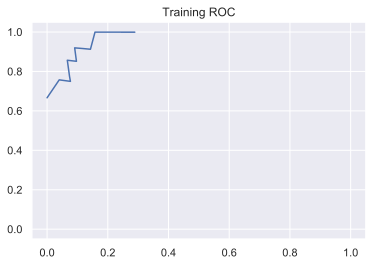

In [217]:
pred_train = model_snippet.predict(X_train)
pred_train_class = np.argmax(pred_train, axis=1)

falsepos = np.zeros(25)
truepos = np.zeros(25)
for threshold in range(25):
    numsnips = n_train_0 + n_train_1
    npts = X_train.shape[0]//(numsnips)
    y_snippet = y_train.reshape(numsnips,numpts)
    prediction_snippet = pred_train_class.reshape(numsnips,numpts)

    snippet_true = np.sum(y_snippet,axis=1) > 0
    snippet_predict = np.sum(prediction_snippet,axis=1) > threshold
    
    CM = sklearn.metrics.confusion_matrix(snippet_true, snippet_predict )
    falsepos[threshold] = CM[0,1]/(np.sum(CM[:,1])+.01)
    truepos[threshold] = CM[0,0]/(np.sum(CM[:,0])+.01)
    
plt.plot(falsepos,truepos)
plt.xlim(-.05,1.05)
plt.ylim(-.05,1.05)
plt.title('Training ROC')
print(falsepos)
print(truepos)

Snippet Level Confusion:
[[15  1]
 [ 1 19]]


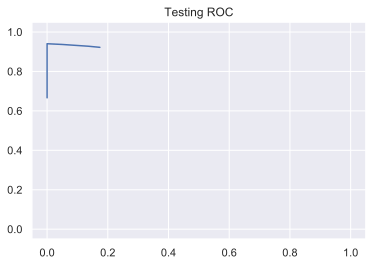

In [221]:
thresholdFromTrain=6

falsepos = np.zeros(25)
truepos = np.zeros(25)
for threshold in range(25):
    numsnips = (num_snips_0-(n_train_0+n_val_0)) + (num_snips_1-(n_train_1+n_val_1))
    numpts = (predict_class.shape[0])//numsnips
    
    prediction_snippet = predict_class.reshape(numsnips,numpts)
    y_snippet = y_test.reshape(numsnips,numpts)

    snippet_true = np.sum(y_snippet,axis=1) > 0
    snippet_predict = np.sum(prediction_snippet,axis=1) > threshold
    
    CM = sklearn.metrics.confusion_matrix(snippet_true, snippet_predict )
    falsepos[threshold] = CM[0,1]/(np.sum(CM[:,1])+.01)
    truepos[threshold] = CM[0,0]/(np.sum(CM[:,0])+.01)
    
plt.plot(falsepos,truepos)
plt.xlim(-.05,1.05)
plt.ylim(-.05,1.05)
plt.title('Testing ROC')

snippet_true = np.sum(y_snippet,axis=1) > 0
snippet_predict = np.sum(prediction_snippet,axis=1) > thresholdFromTrain 
CM_test = sklearn.metrics.confusion_matrix(snippet_true, snippet_predict )

print('Snippet Level Confusion:')
print(CM_test)

In [118]:
pred_all = model_snippet.predict(Psi)
pred_all_class = np.argmax(pred_all, axis=1)


z_downsample = np.empty((0,zs[0].shape[1]+1), float)
for i in range(len(zs)):
    x = zs[i]
    x = x[0:x.shape[0]-H,:]
    x = x[::step_size]
    if i<z_breakpoint:
        x = np.append(x,np.zeros((x.shape[0],1)),1)
    else:
        x = np.append(x,np.ones((x.shape[0],1)),1)

    z_downsample = np.append(z_downsample,x,0)
    
z_downsample = np.append(z_downsample, manifolder.snip_number.reshape(Psi.shape[0],1), 1)
z_downsample = np.append(z_downsample, pred_all_class.reshape(Psi.shape[0],1), 1)
    
z_downsample.shape

(6592, 4)

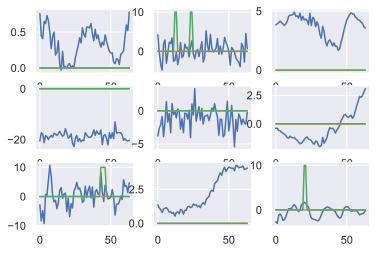

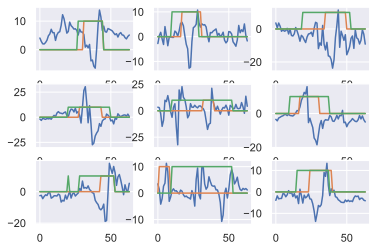

In [119]:
plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(z_downsample[snippet_label==snip_test_0[i]][:,5])
    else:
        plt.plot(z_downsample[snippet_label==snip_test_0[i]][:,0])
    plt.plot(10*locallabel_downsample[snippet_label==snip_test_0[i]])
    plt.plot(10*pred_all_class[snippet_label==snip_test_0[i]])
    
plt.show()
 
plt.figure()
for i in range(9):
    plt.subplot(3,3,i+1)
    if reduce_dimension==False:
        plt.plot(z_downsample[snippet_label==snip_test_1[i]][:,5])
    else:
        plt.plot(z_downsample[snippet_label==snip_test_1[i]][:,0])
    plt.plot(10*locallabel_downsample[snippet_label==snip_test_1[i]])
    plt.plot(10*pred_all_class[snippet_label==snip_test_1[i]])

    
plt.show()

In [131]:
np.savetxt('astro_deep_learning_snippetSplit.csv', z_downsample, delimiter=',', fmt='%f')